In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [4]:
!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   2018      0  0:00:01  0:00:01 --:--:--  2025


In [5]:
df=pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [6]:
df['LogPassengers']=np.log(df['Passengers'])

In [7]:
df['DiffLogPassengers']=df['LogPassengers'].diff()

In [8]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [9]:
# Make supervised dataset
# Let's see if we can use T past values to predict the next value

series=df['DiffLogPassengers'].to_numpy()[1:] # Numpy array are little easier to index
# It starts from 1 as due to taking the first difference the first value is zero
T=10 # We set the number of lags.
X=[] # We also create empty lists to store inputs and targets
Y=[]

for t in range(len(series)-T):
    x=series[t:t+T] # This is our input which is of the time series of size T
    X.append(x)
    y=series[t+T] # This is to compute the target which is the next value of the time series
    Y.append(y)
    
# We convert both the inputs and targets to the numpy array, which are easy to index    
X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (133, 10) Y.shape (133,)


In [10]:
# To split our input and targets into train and test
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [11]:
# To fit a linear regression
lr=LinearRegression()
lr.fit(Xtrain,Ytrain)
lr.score(Xtrain,Ytrain)

0.6837135048453122

In [12]:
lr.score(Xtest,Ytest)

0.6492870172668168

In [13]:
# The next step is to create Boolean Index to index both the train and test set
train_idx=df.index<=train.index[-1]
test_idx=~train_idx
train_idx[:T+1]=False # first T+1 values are not predictable

In [14]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers']=df['LogPassengers'].shift(1)
prev=df['ShiftLogPassengers']

In [15]:
# Last-known train value
last_train=train.iloc[-1]['LogPassengers']

In [16]:
# To assign the 1 step forecast to the dataframe
df.loc[train_idx,'LR_1step_train']=prev[train_idx]+lr.predict(Xtrain)
df.loc[test_idx,'LR_1step_test']=prev[test_idx]+lr.predict(Xtest)

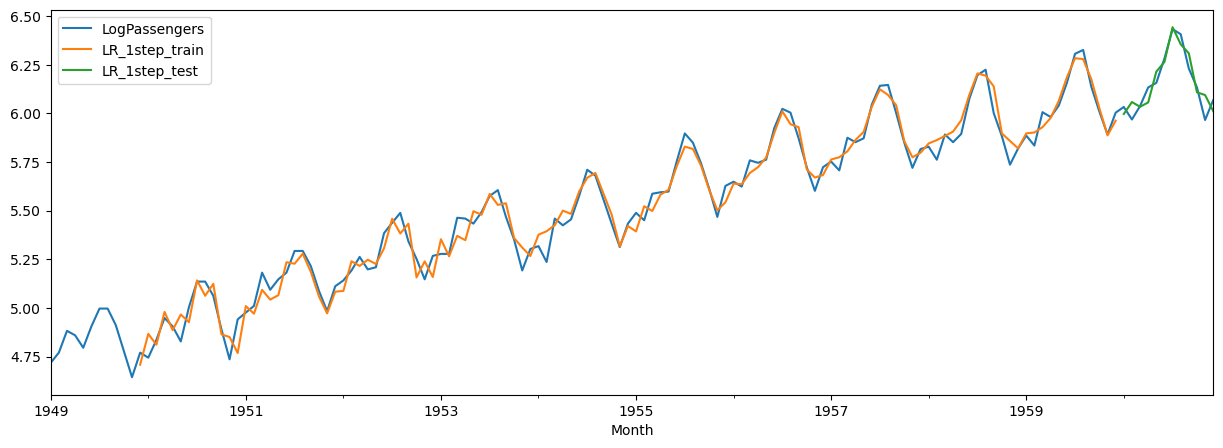

In [17]:
# to plot our 1 step forecast
df[['LogPassengers','LR_1step_train','LR_1step_test']].plot(figsize=(15,5));

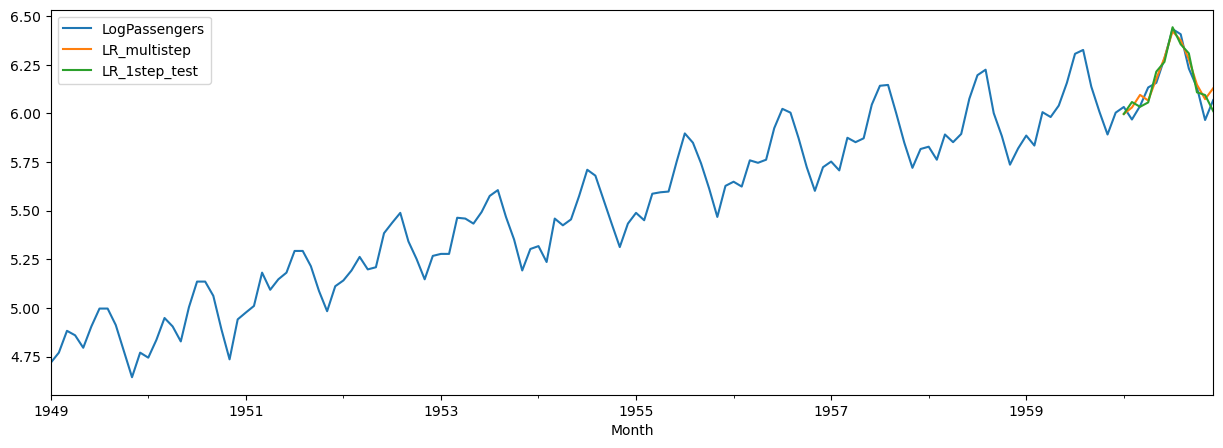

In [23]:
# results look pretty good
multistep_predictions=[] # empty list to store our predictions

#to obtain the first test input
last_x=Xtest[0]  # This variable will be updated as we go through the loop

while len(multistep_predictions)< Ntest:
    p=lr.predict(last_x.reshape(1,-1))[0] # we have to reshape as scikit learn only accepts 2 d array as input
    # ...continued. Data has to be in the form of a table with samples along the rows and features along the columns.
    # we index the prediction to 0, [0] since there is only one prediction
    
    # update the predictions list
    multistep_predictions.append(p) # to append our prediction to a list of predictions
    
    # make the new input
    last_x=np.roll(last_x,-1) # update last x, basically throw out the oldest value and append the newest value
    last_x[-1]=p
    # First we rotate the values by one step: roll[1,2,3,4,5] -> [2,3,4,5,1] then we assign at -1 
    #...for example we want to assign 6 then the list will become [2,3,4,5,6]
    
    
# save multi-step forecast to dataframe
df.loc[test_idx,'LR_multistep']=last_train+np.cumsum(multistep_predictions)

# plot 1-step and multi-step forecast
df[['LogPassengers','LR_multistep','LR_1step_test']].plot(figsize=(15,5));

In [24]:
#  this is also good

# Lets create a multi output model
# make multi-output supervised dataset
Tx=T # Number of timesteps in the input
Ty=Ntest # Number of steps in the output
X=[]
Y=[]
for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty] # the loop has a length of Ty
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [25]:
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [26]:
lr=LinearRegression()
lr.fit(Xtrain_m,Ytrain_m)
lr.score(Xtrain_m,Ytrain_m)

0.8141637147930583

In [27]:
r2_score(lr.predict(Xtest_m).flatten(),Ytest_m.flatten())

0.7690077978619654

In [28]:
# Save multi-output forecast to dataframe
df.loc[test_idx,'LR_multioutput']= last_train+\
np.cumsum(lr.predict(Xtest_m).flatten())

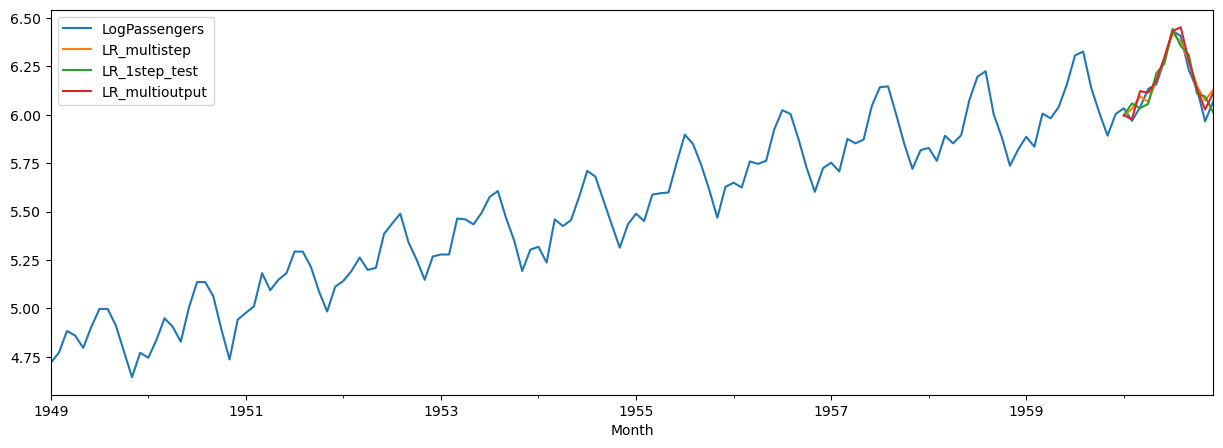

In [29]:
# plot all forecast
cols=['LogPassengers','LR_multistep','LR_1step_test','LR_multioutput']
df[cols].plot(figsize=(15,5));

In [30]:
# MAPE
mape1=mean_absolute_percentage_error(Ytest,multistep_predictions)
print('multi-step MAPE:',mape1)
mape2=mean_absolute_percentage_error(
Ytest,df.loc[test_idx,'LR_multioutput'])
print('multi-output MAPE',mape2)

multi-step MAPE: 0.8871565063810568
multi-output MAPE 103.81514014407144


# Test Other Models

In [35]:
def one_step_and_multistep_forecast(model,name):
    model.fit(Xtrain,Ytrain)
    print('One-step forecast:',name)
    # print('Train R^2:',model.score(Xtrain,Ytrain))
    # print('Test R^2(1-step):',model.score(Xtest,Ytest))
    
    # store 1-step forecast
    df.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+model.predict(Xtrain)
    df.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+model.predict(Xtest)
    
    # generate multi-step forecast
    multistep_predictions=[]
    
    # first test input
    last_x=Xtest[0]
    
    while len(multistep_predictions)<Ntest:
        p=model.predict(last_x.reshape(1,-1))[0]
        
        #update the prediction list
        multistep_predictions.append(p)
        
        # make the new input
        last_x=np.roll(last_x,-1)
        last_x[-1]=p
        
    # store multi-step forecast
    df.loc[test_idx,f'{name}_multistep_test']=last_train+np.cumsum(multistep_predictions)
    
    #MAPE of multi-step forecast
    test_log_pass=df.iloc[-Ntest:]["LogPassengers"]
    mape= mean_absolute_percentage_error(test_log_pass,df.loc[test_idx,f'{name}_multistep_test'])
    print('Test MAPE (multistep):',mape)
    
    #plot 1-step and multistep forecast
    cols=[
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot(figsize=(15,5));
        

One-step forecast: SVR
Test MAPE (multistep): 0.01214912210239275


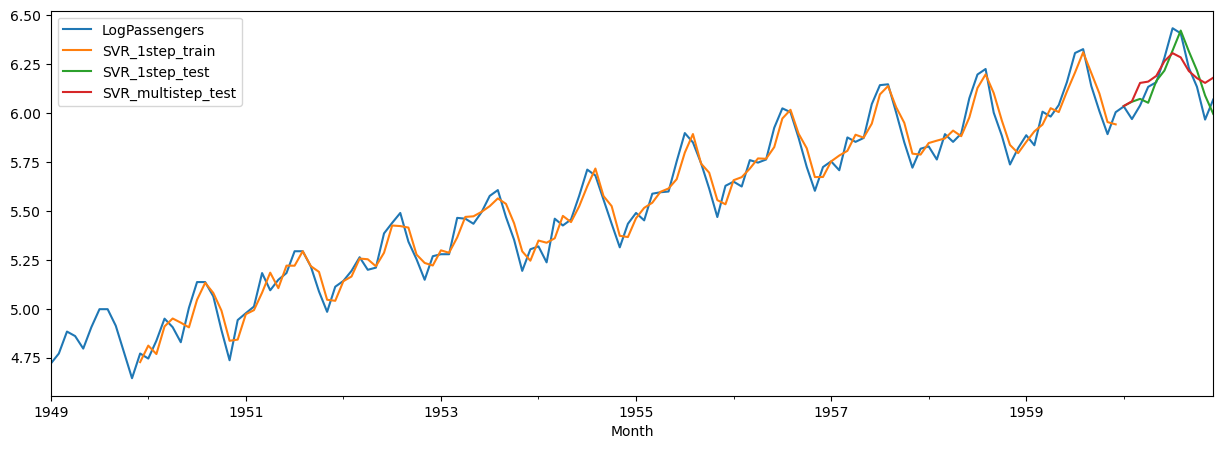

In [36]:
one_step_and_multistep_forecast(SVR(),'SVR')

One-step forecast: RF
Test MAPE (multistep): 0.005516758109622666


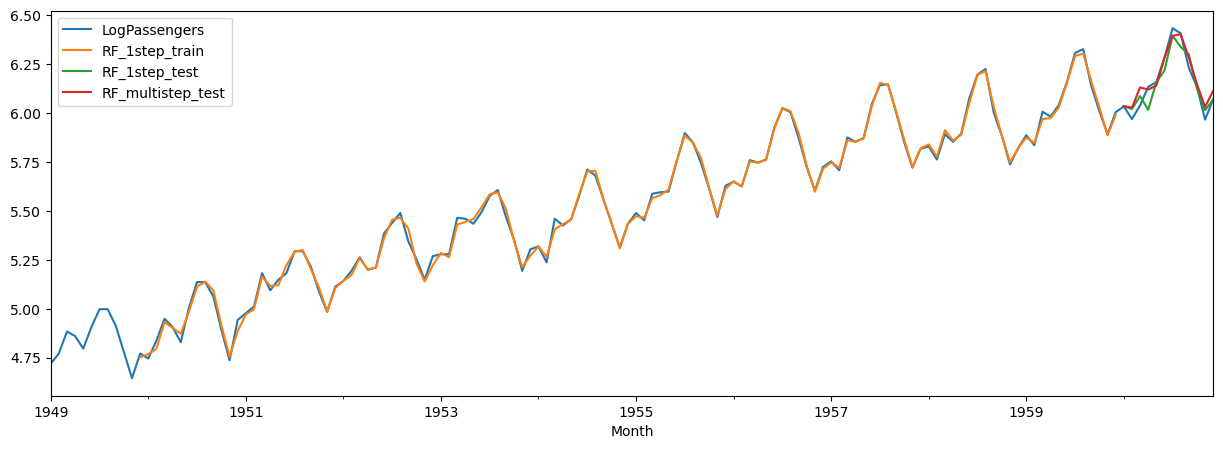

In [37]:
## SVM doesn't peform that well, but this is without differencing
one_step_and_multistep_forecast(RandomForestRegressor(),'RF')

In [38]:
# this does pretty well

In [48]:
def multi_output_forecast(model,name):
    model.fit(Xtrain_m,Ytrain_m)
    
    # save multioutput forecast to dataframe
    df.loc[test_idx,f'{name}_multioutput']=last_train+np.cumsum(model.predict(Xtest_m).flatten())
    test_log_pass=df.iloc[-Ntest:]["LogPassengers"]
    mape=mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,f'{name}_multioutput'])
    print('Test MAPE (multi-output):',mape)
    
    #plot all forecasts
    #assume that previous functions have been run
    cols=[
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df[cols].plot(figsize=(15,5));

In [49]:
# multi_output_forecast(SVR(),'SVR') # cannot handle multi-output

In [50]:
class SVRWrapper:
    def __init__(self,h,**args):
        self.h=h
        self.models=[SVR(**args) for _ in range(h)]
        
        
    def fit(self,X,Y):
        for k in range(self.h):
            self.models[k].fit(X,Y[:,k])
            
    def predict(self,X):
        P=[m.predict(X) for m in self.models]
        return np.hstack(P)

Test MAPE (multi-output): 0.010731361803536803


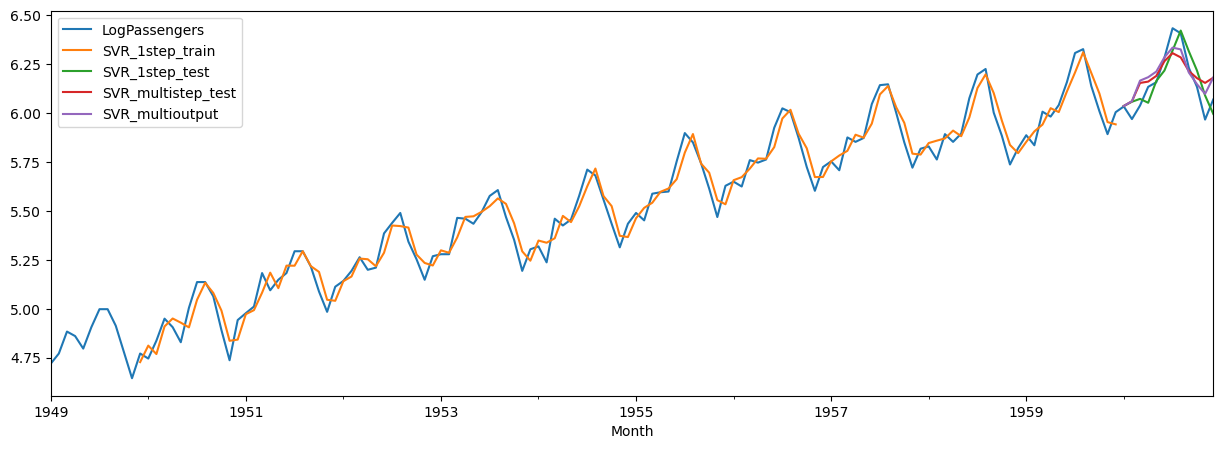

In [51]:
multi_output_forecast(SVRWrapper(Ntest),'SVR')

Test MAPE (multi-output): 0.00441547344233452


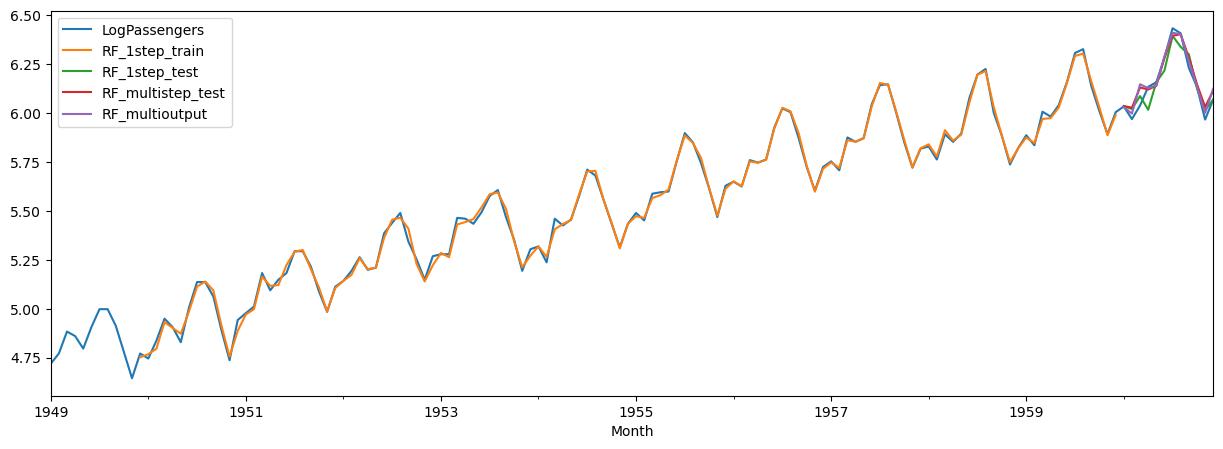

In [52]:
# doesn't perform too well
multi_output_forecast(RandomForestRegressor(),'RF')

In [ ]:
# We see that random forest does very well